<a href="https://colab.research.google.com/github/idrimadrid/Deep_learning_Segmentation_CAMUS_challenge/blob/main/Camus_challenge_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

In [ ]:
!pip install keras-metrics
!pip install tf-nightly
!pip install -U efficientnet==0.0.4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
import numpy as np
import nibabel as nib
from glob import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import clear_output
from math import ceil
import tensorflow.keras as keras
import keras_metrics as km
from sklearn.metrics import f1_score
import random
import os

In [ ]:
len(os.listdir("/content/drive/My Drive/training/"))

310

# DATA Loading

*   Good 2CH (ED+ES) 396 samples


In [ ]:
def load_data(data_path,rows,cols,channel):
  data = glob(data_path)#+glob(data_path_medium)
  total=len(data)
  imgs = []
  masks = []
  for count, file in enumerate(data,1):
    img = nib.load(file).get_fdata()
    img = resize(img, (rows, cols, channel))        
    imgs.append(img)
    label = nib.load(file[:-6]+'gt.nii').get_fdata()
    label = resize(label, (rows, cols, channel))
    masks.append(label)
    clear_output(wait=True)
    print("{} / {}".format(count,total))
  return np.array(imgs),np.array(masks)

In [ ]:
DATA_PATH="/content/drive/My Drive/Colab/dataset/train/2CH/Good/*US.nii"
IMG_WIDTH = 352
IMG_HEIGHT = 352
CHANNELS = 1

IMAGES,LABELS=load_data(DATA_PATH,IMG_WIDTH,IMG_HEIGHT,CHANNELS)
#data splitting
train_X,test_X,train_Y,test_Y = train_test_split(IMAGES,
                                                  LABELS,
                                                  test_size=0.1)

396 / 396


Dataset Building

In [ ]:
train = tf.data.Dataset.from_tensor_slices((train_X,train_Y))
test = tf.data.Dataset.from_tensor_slices((test_X,test_Y))

DATA Normalisation

In [ ]:
def normalize(input_image, input_mask):
  """ normalisation [0..1] """
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask = tf.cast(input_mask, tf.float32)
  return input_image, input_mask

In [ ]:
train=train.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test=test.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Dataset Creation

In [ ]:
TRAIN_LENGTH = train_X.shape[0]
BATCH_SIZE = 16
STEPS_PER_EPOCH = ceil(TRAIN_LENGTH / BATCH_SIZE)
BUFFER_SIZE=1000

train_dataset = train.cache().shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE).repeat()
test_dataset = test.batch(1)

DATASET Visualisation

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

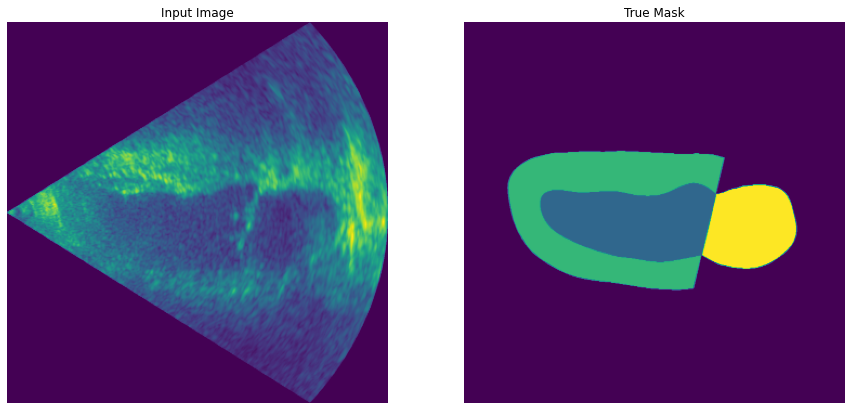

In [ ]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

# Model Creation

In [ ]:
#Num Classes
OUTPUT_CHANNELS = 4

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=[IMG_WIDTH,IMG_HEIGHT, CHANNELS] ,include_top=False,weights=None)

# Use the activations of these layers
layer_names = [
    'block2a_expand_activation',   # 64x64
    'block3a_expand_activation',   # 32x32
    'block4a_expand_activation',   # 16x16
    'block6a_expand_activation',  # 8x8
    'top_activation',      # 4x4
  #  'block_1_expand_relu',   # 64x64
  #  'block_3_expand_relu',   # 32x32
  #  'block_6_expand_relu',   # 16x16
  #  'block_13_expand_relu',  # 8x8
  #  'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = True

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())
  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))
  result.add(tf.keras.layers.ReLU())
  return result
  
up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT, CHANNELS])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same',activation='softmax')  #64x64 -> 128x128
  
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

HyperParameters

In [ ]:
def dice_coefficient(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[-3,-2,-1])
    dn = K.sum(K.square(y_true) + K.square(y_pred), axis=[-3,-2,-1]) + 1e-8
    return K.mean(2 * intersection / dn, axis=[0,1])


def loss_gt(e=1e-8):
    """
    loss_gt(e=1e-8)
    ------------------------------------------------------
    Since keras does not allow custom loss functions to have arguments
    other than the true and predicted labels, this function acts as a wrapper
    that allows us to implement the custom loss used in the paper. This function
    only calculates - L<dice> term of the following equation. (i.e. GT Decoder part loss)
    
    L = - L<dice> + weight_L2 ∗ L<L2> + weight_KL ∗ L<KL>
    
    Parameters
    ----------
    `e`: Float, optional
        A small epsilon term to add in the denominator to avoid dividing by
        zero and possible gradient explosion.
        
    Returns
    -------
    loss_gt_(y_true, y_pred): A custom keras loss function
        This function takes as input the predicted and ground labels, uses them
        to calculate the dice loss.
        
    """
    def loss_gt_(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[-3,-2,-1])
        dn = K.sum(K.square(y_true) + K.square(y_pred), axis=[-3,-2,-1]) + e
        
        return - K.mean(2 * intersection / dn, axis=[0,1])
    
    return loss_gt_


dice_e=1e-8

model.compile(
        adam(lr=1e-4),
        [loss_gt(dice_e), loss_VAE(input_shape, z_mean, z_var, weight_L2=weight_L2, weight_KL=weight_KL)],
        metrics=[dice_coefficient]
    )

In [ ]:
def dice(mask ,pred):
  labels=mask.astype('float64')
  predictions=pred.astype('float64')
  num_classes=4
  scores = []
  for i in range(1,num_classes):
    union = np.count_nonzero(predictions == i) + np.count_nonzero(labels == i)
    intersection = 2. * np.count_nonzero((np.asarray(predictions == i, np.uint8) * np.asarray(labels == i, np.uint8))) / union
    scores.append(intersection)
  return sum(scores) / len(scores)


In [ ]:
def dice_loss(mask ,pred):
  
  labels=mask.astype('float64')
  predictions=pred.astype('float64')
  num_classes=4
  scores = []
  for i in range(1,num_classes):
    union = np.count_nonzero(predictions == i) + np.count_nonzero(labels == i)
    intersection = 2. * np.count_nonzero((np.asarray(predictions == i, np.uint8) * np.asarray(labels == i, np.uint8))) / union
    scores.append(intersection)
  return sum(scores) / len(scores)

# Model Fine Tuning

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

Model Visuallisation

In [ ]:
tf.keras.utils.plot_model(base_model , show_shapes=True, dpi=64)

In [ ]:
model.summary()

Output Processing

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

# Model Training

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    scores=[]
    #compute F1 score :
    for image, mask in test_dataset.take(test_X.shape[0]):
      val_predict = np.asarray(create_mask(self.model.predict(image)))
      val_targ = np.asarray(mask)
      val_f1 = dice(val_targ, val_predict)
      scores.append(val_f1)
    scores = sum(scores) / len(scores)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))    
    show_predictions()
    print("-- Validation_f1_score: {}".format(scores))
    print("-"*50)

#  early stopping
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20, restore_best_weights=True)
#  DisplayCallback
Display=DisplayCallback()


Sample Prediction after epoch 100



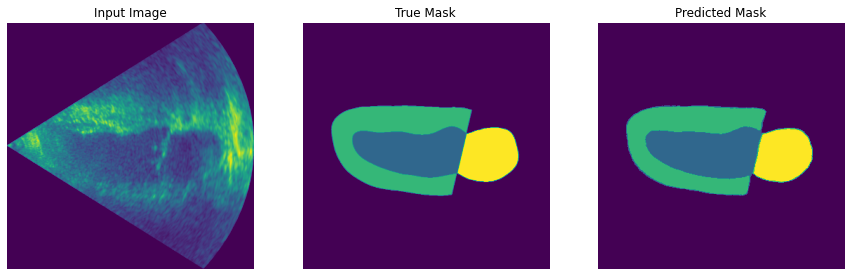

-- Validation_f1_score: 0.8705711913705855
--------------------------------------------------
23/23 [==============================] - 16s 688ms/step - loss: 0.0279 - accuracy: 0.9705 - val_loss: 0.2635 - val_accuracy: 0.9421


In [ ]:
EPOCHS = 100

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=test_dataset,
                          callbacks=[Display])                      

# Model Evaluation

In [ ]:
from IPython.display import clear_output
from keras.callbacks import ModelCheckpoint

class DisplayCallback(tf.keras.callbacks.Callback):
  
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))    
    print("-"*50)
    show_predictions()

checpointer= tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/model__medic.h5', verbose=1, save_best_only=True, save_weights_only=False)
#checpointer = [tf.keras.callbacks.experimental.BackupAndRestore(backup_dir='/content/drive/My Drive/model_for_medic.h5')]

#  early stopping
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='dice_coefficient', mode='max', verbose=1,patience=1, restore_best_weights=True)
#  DisplayCallback
Display=[
         DisplayCallback(),
         EarlyStop,
         checpointer,
]

In [ ]:
checpointer= tf.keras.callbacks.ModelCheckpoint('model_for_medic.h5', verbose=1, save_best_only=True)

callbacks= [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    checpointer
]

entrain=models.fit(train_X,train_Y, batch_size=2,steps_per_epoch=50,epochs=10,callbacks=callbacks)



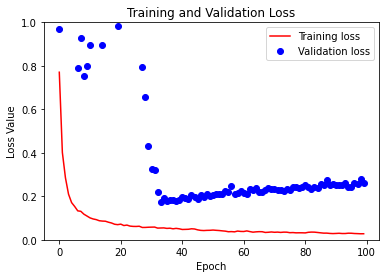

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(100)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


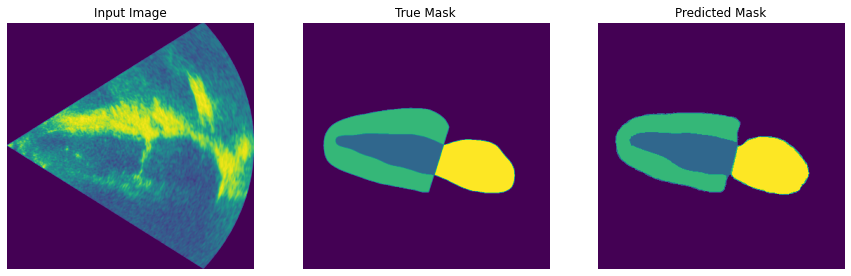

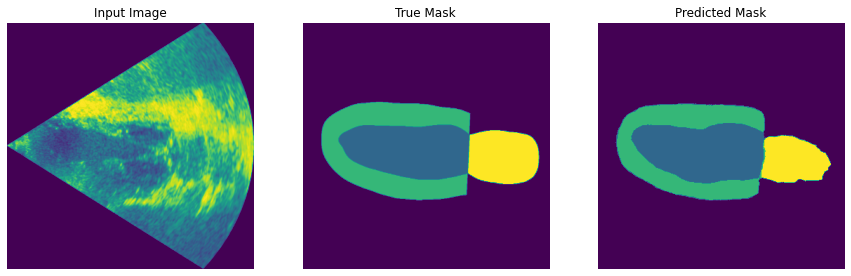

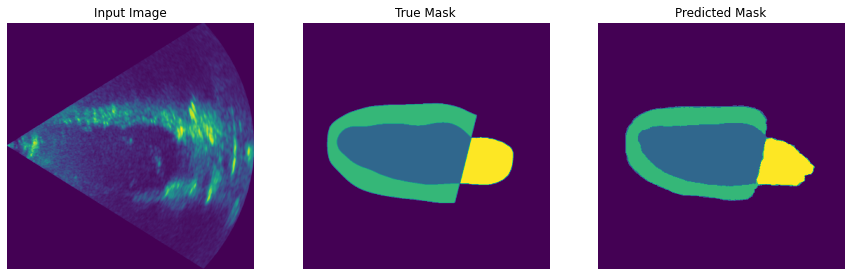

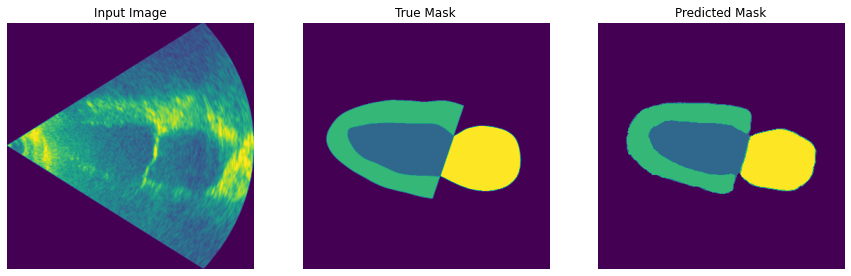

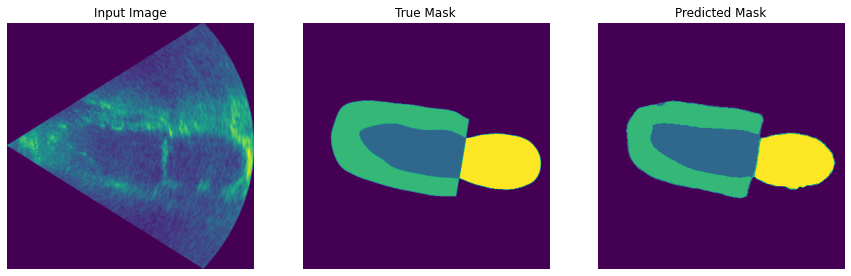

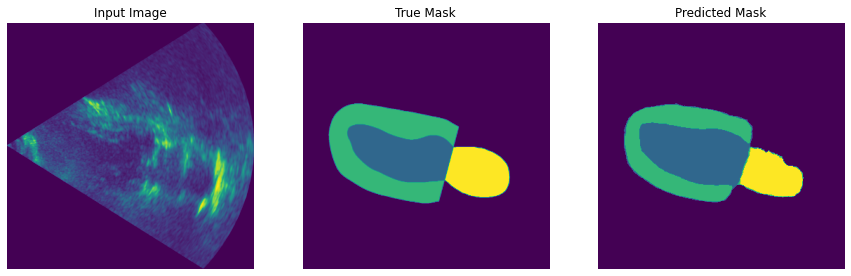

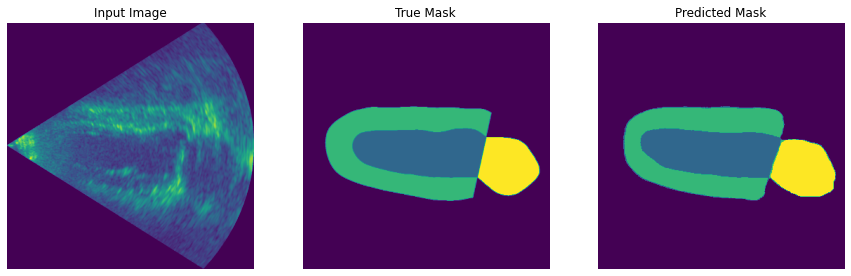

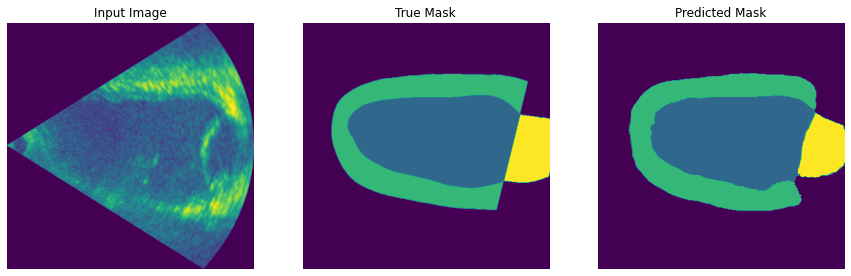

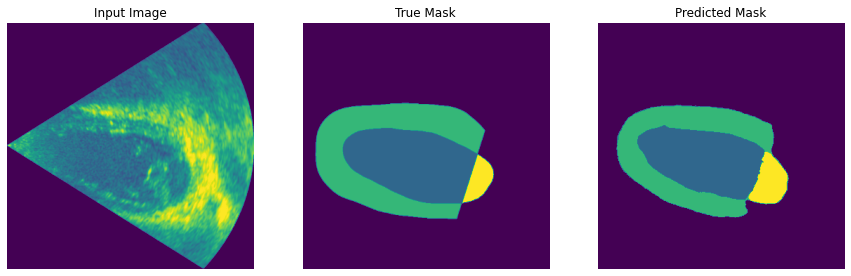

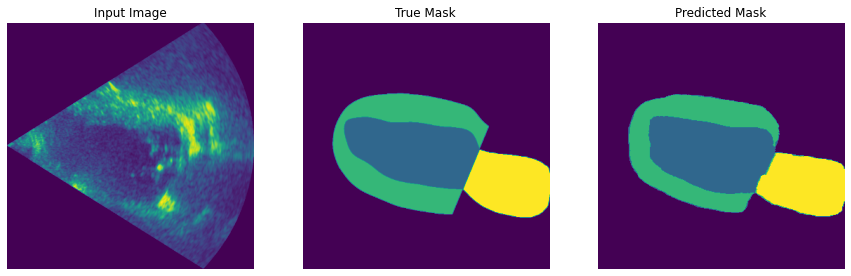

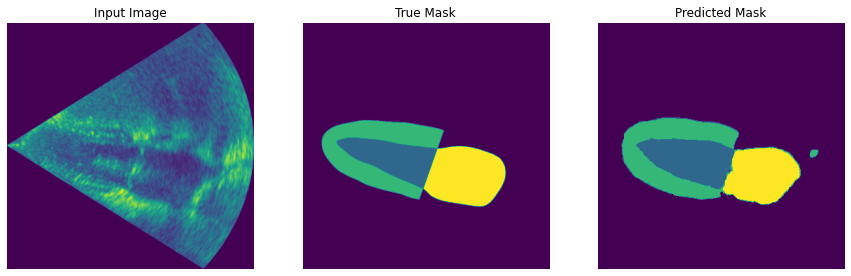

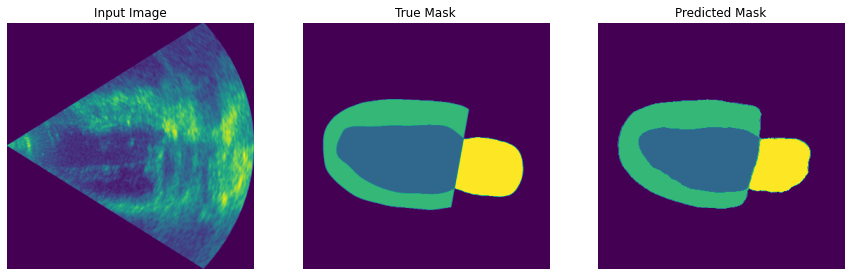

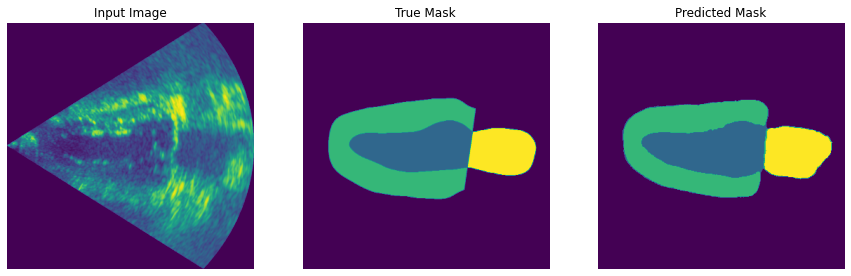

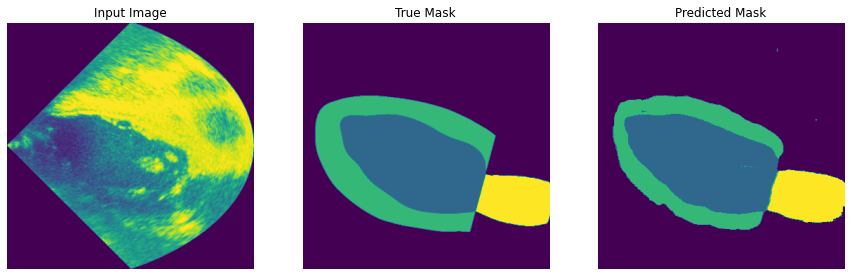

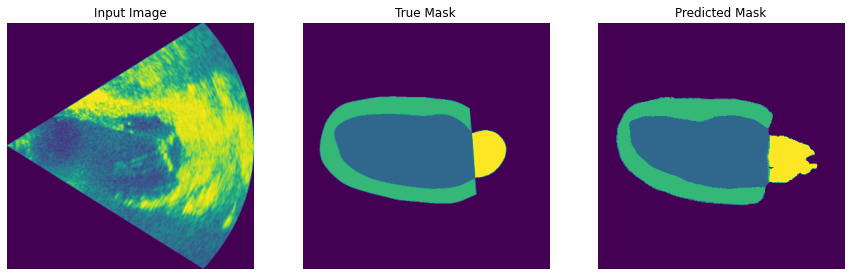

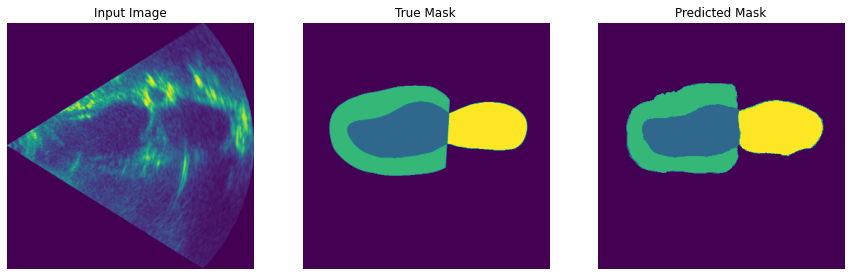

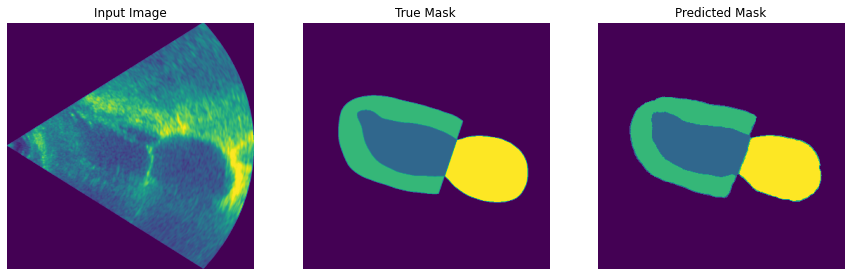

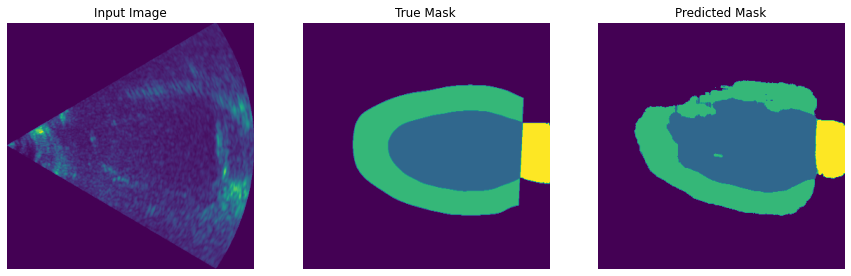

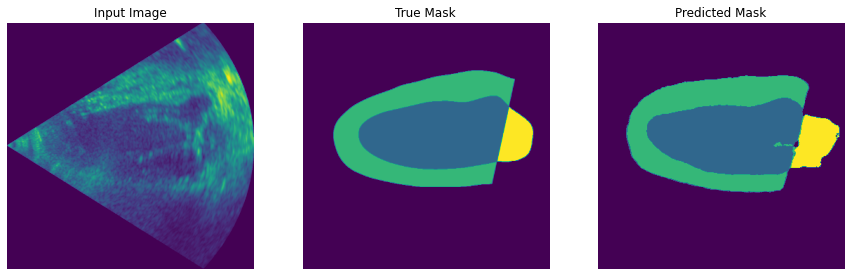

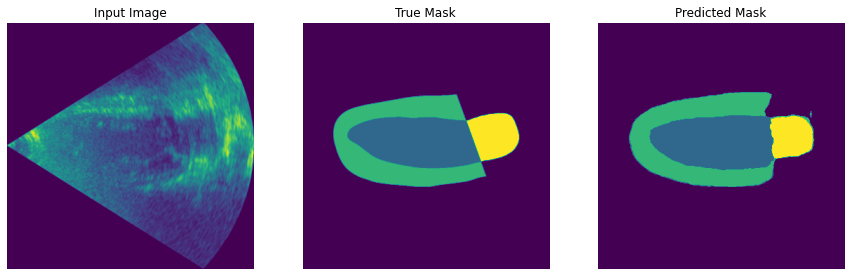

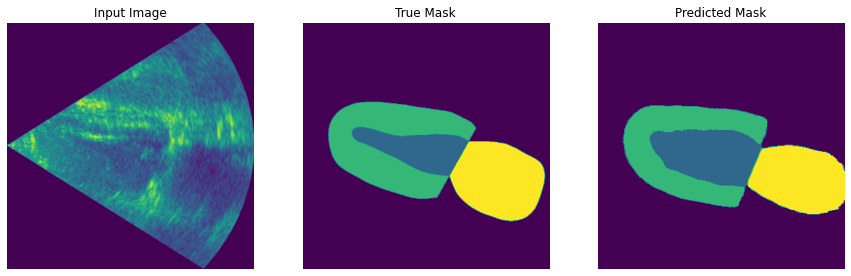

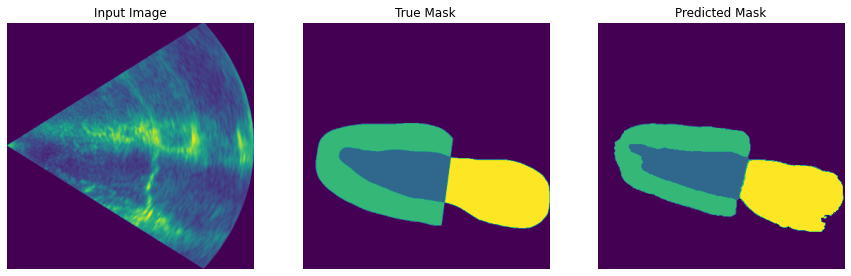

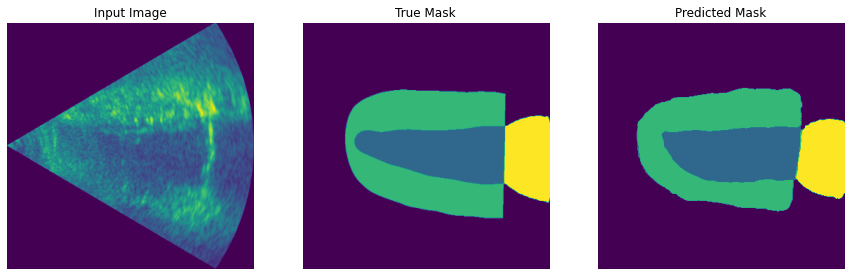

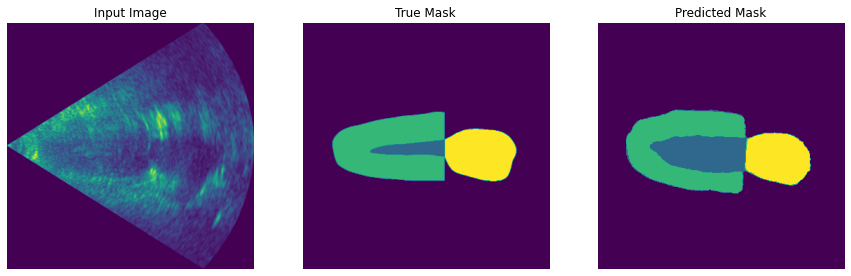

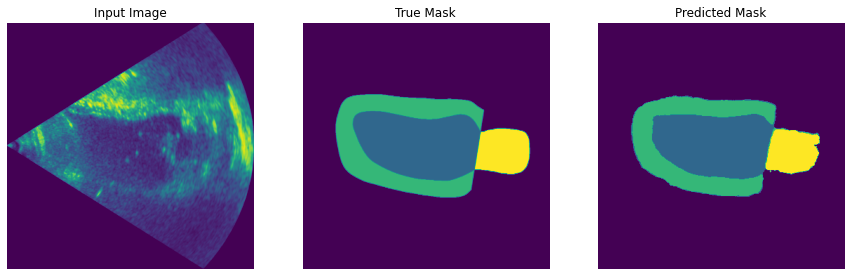

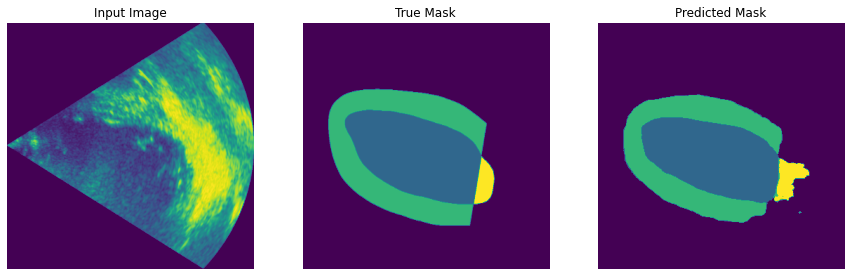

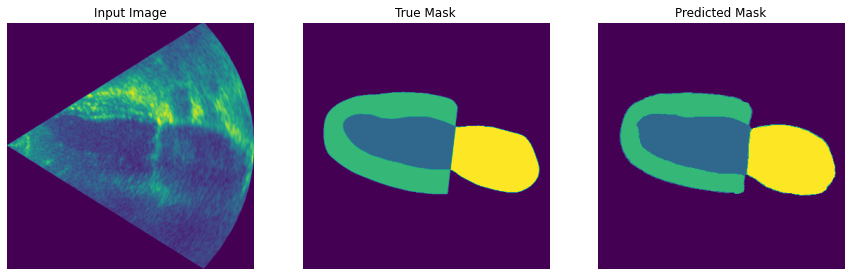

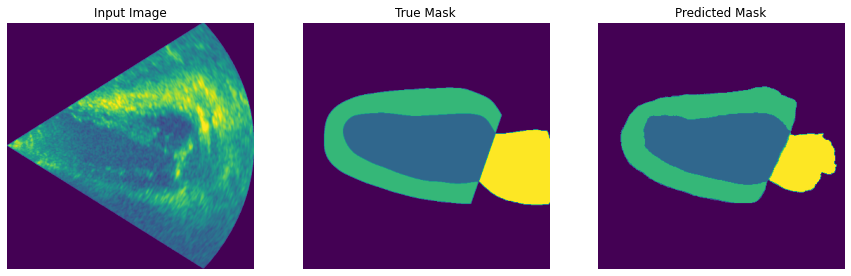

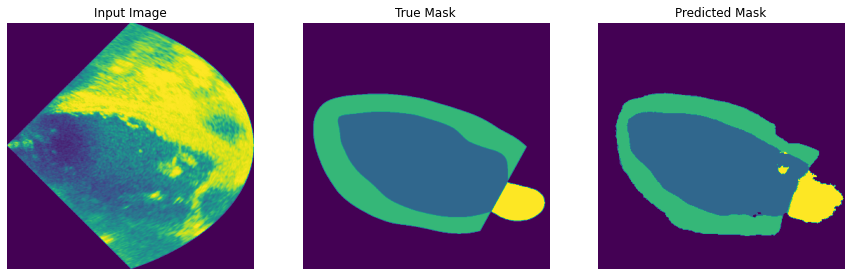

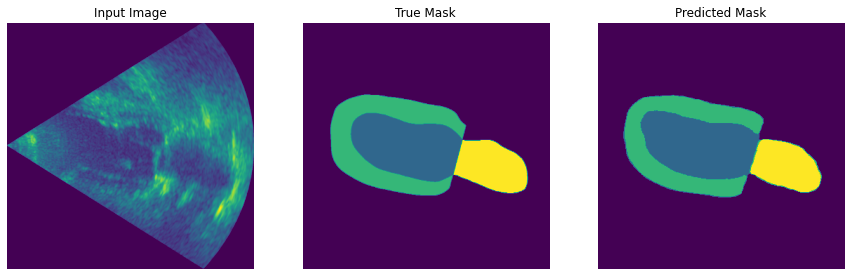

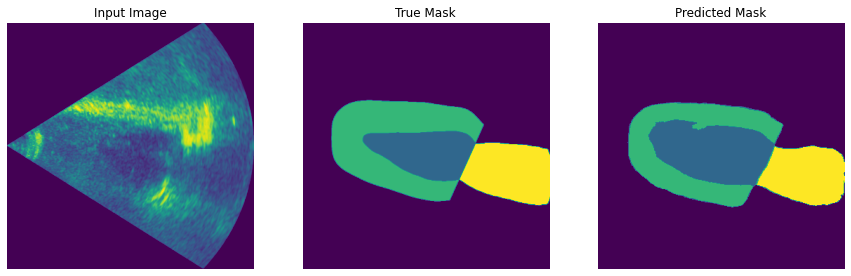

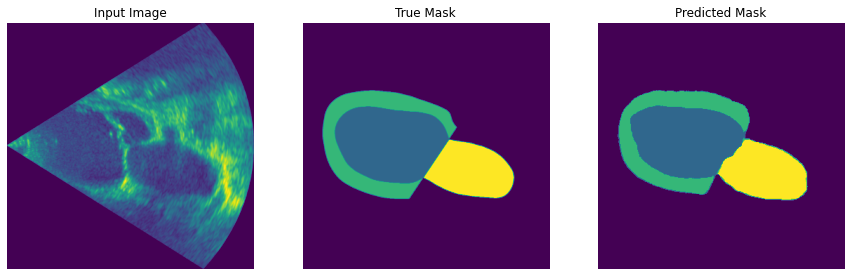

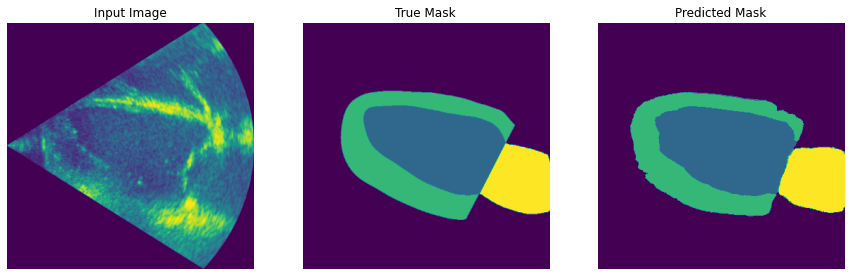

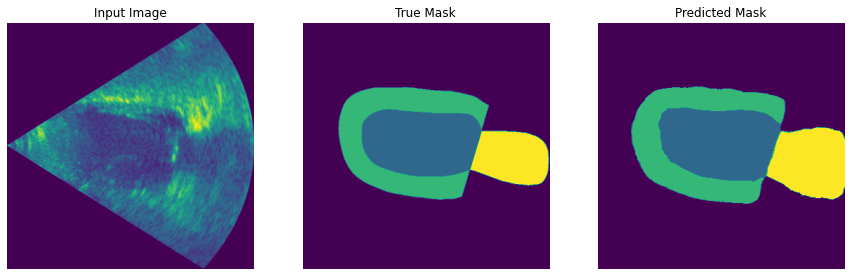

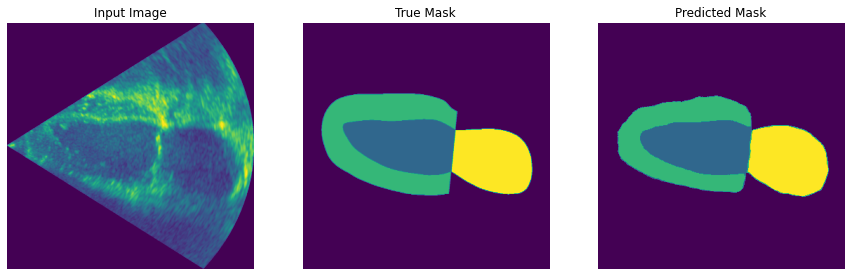

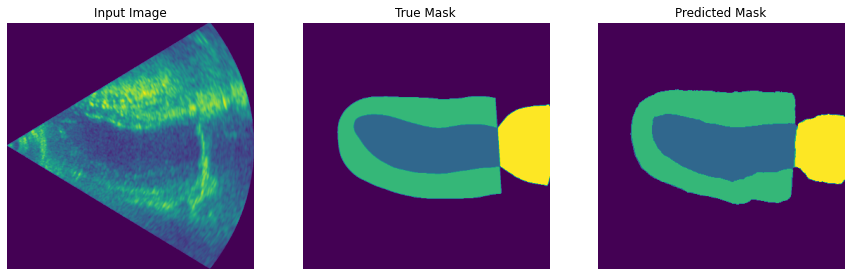

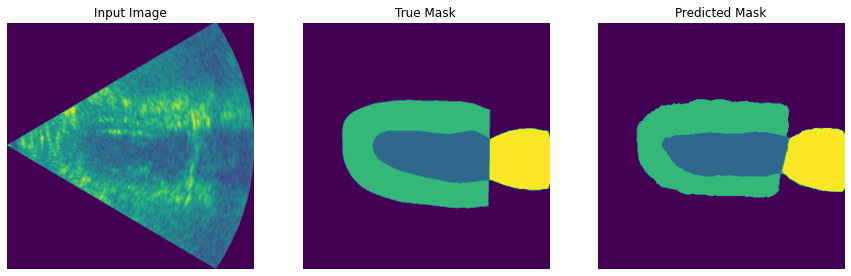

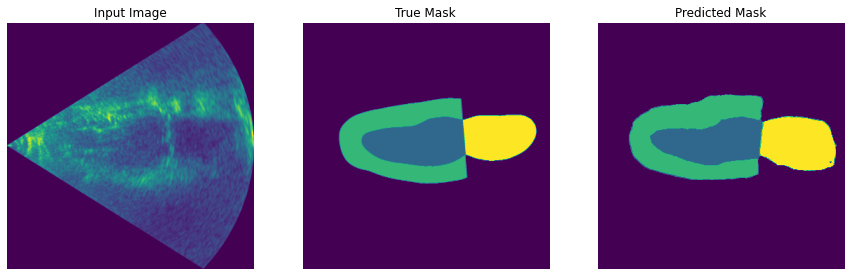

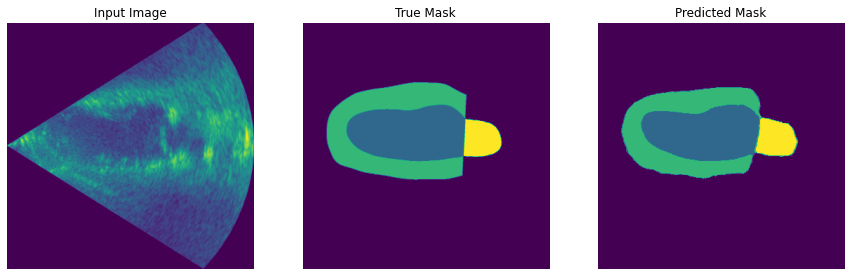

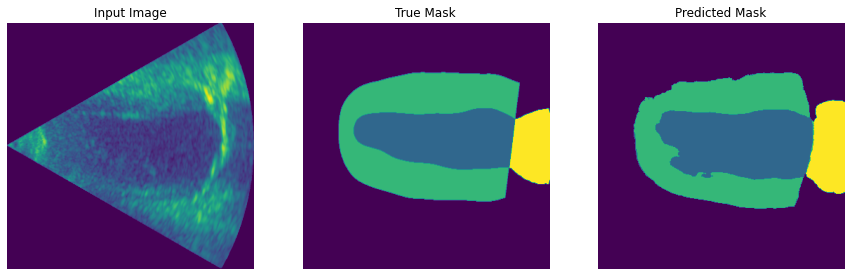

In [ ]:
show_predictions(test_dataset,test_X.shape[0])

In [ ]:
model.save("/content/drive/My Drive/Colab/model_good_medium", save_format="h5")